### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import learning_curve

### Load and Clean Dataset

In [2]:
#Load the dataset
train = pd.read_csv('spam.csv', encoding = 'latin-1')
train_df=train

In [3]:
# Drop unnecessary columns
train_df = train_df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'])

# Rename columns for clarity
train_df.columns = ['label', 'text']

# Display the cleaned dataset
print(train_df.head())

# Basic statistics
print(train_df['label'].value_counts())
print(train_df['text'].apply(len).describe())

  label                                               text
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...
label
ham     4825
spam     747
Name: count, dtype: int64
count    5572.000000
mean       80.118808
std        59.690841
min         2.000000
25%        36.000000
50%        61.000000
75%       121.000000
max       910.000000
Name: text, dtype: float64


### Text Preprocessing

In [4]:
# Download stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

# Clean text function
def clean_text(text):
    '''Make text lowercase, remove text in square brackets, remove links, remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

# Text preprocessing function
def preprocess_text(text):
    text = clean_text(text)
    tokens = text.split()
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)


[nltk_data] Downloading package stopwords to /home/vivek/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
# Apply preprocessing to the text data
train_df['clean_text'] = train_df['text'].apply(preprocess_text)

### Splitting Data and Vectorization

In [6]:

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(train_df['clean_text'], train_df['label'], test_size=0.2, random_state=42)

#Count of the Splitted dataset
print(len(X_train), len(y_train))
print(len(X_test), len(y_test))

# Output the first few rows of the cleaned data
print(train_df.head())

# Initialize CountVectorizer with specified parameters
count_vectorizer = CountVectorizer(stop_words='english', ngram_range=(1,2), min_df=2, max_df=0.95, max_features=100)

# Fit and transform the training data with CountVectorizer
X_train_count = count_vectorizer.fit_transform(X_train)

# Transform the testing data with CountVectorizer
X_test_count = count_vectorizer.transform(X_test)

# Initialize TF-IDF Transformer
tfidf_transformer = TfidfTransformer()

# Fit and transform the training data with TF-IDF
X_train_tfidf = tfidf_transformer.fit_transform(X_train_count)

# Transform the testing data with TF-IDF
X_test_tfidf = tfidf_transformer.transform(X_test_count)

# Output the shape of the TF-IDF transformed data
print(f'Train TF-IDF Shape: {X_train_tfidf.shape}')
print(f'Test TF-IDF Shape: {X_test_tfidf.shape}')


4457 4457
1115 1115
  label                                               text  \
0   ham  Go until jurong point, crazy.. Available only ...   
1   ham                      Ok lar... Joking wif u oni...   
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...   
3   ham  U dun say so early hor... U c already then say...   
4   ham  Nah I don't think he goes to usf, he lives aro...   

                                          clean_text  
0  go jurong point crazi avail bugi n great world...  
1                              ok lar joke wif u oni  
2  free entri wkli comp win fa cup final tkt may ...  
3                u dun say earli hor u c alreadi say  
4          nah dont think goe usf live around though  
Train TF-IDF Shape: (4457, 100)
Test TF-IDF Shape: (1115, 100)


### Grid Search and Model Evaluation

In [7]:

# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'solver': ['newton-cg', 'lbfgs', 'liblinear']
}

# Initialize Grid Search Cross-Validation
grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=50, scoring='accuracy')

# Fit Grid Search to the training data
grid_search.fit(X_train_tfidf, y_train)

# Get the best parameters and best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Evaluate the best model on the test data
y_pred_best = best_model.predict(X_test_tfidf)
accuracy_best = accuracy_score(y_test, y_pred_best)

# Output the best model's accuracy and metrics
print(f'Best Model Accuracy: {accuracy_best}')
print('Best Model Parameters:', best_params)
print('Classification Report:')
print(classification_report(y_test, y_pred_best))
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred_best))


Best Model Accuracy: 0.9443946188340807
Best Model Parameters: {'C': 1, 'solver': 'liblinear'}
Classification Report:
              precision    recall  f1-score   support

         ham       0.95      0.99      0.97       965
        spam       0.93      0.63      0.75       150

    accuracy                           0.94      1115
   macro avg       0.94      0.81      0.86      1115
weighted avg       0.94      0.94      0.94      1115

Confusion Matrix:
[[958   7]
 [ 55  95]]


### Training and Evaluating the Model

In [8]:
# Initialize and train the Logistic Regression model
model = LogisticRegression(C=1, solver= 'liblinear')
model.fit(X_train_tfidf, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test_tfidf)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(classification_report(y_test, y_pred))
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.9443946188340807
Classification Report:
              precision    recall  f1-score   support

         ham       0.95      0.99      0.97       965
        spam       0.93      0.63      0.75       150

    accuracy                           0.94      1115
   macro avg       0.94      0.81      0.86      1115
weighted avg       0.94      0.94      0.94      1115

Confusion Matrix:
[[958   7]
 [ 55  95]]


### Learning Curves and Confusion Matrix Plotting

In [9]:
# Function to plot learning curves
def plot_learning_curves(model, X_train, y_train, X_test, y_test):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X_train, y_train, cv=5, scoring='accuracy',
        train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(14, 8))
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.title("Learning Curves")
    plt.show()



def plot_confusion_matrix(y_true, y_pred, classes):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', cbar=True,
                xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()



### Plotting Learning Curves and Confusion Matrix

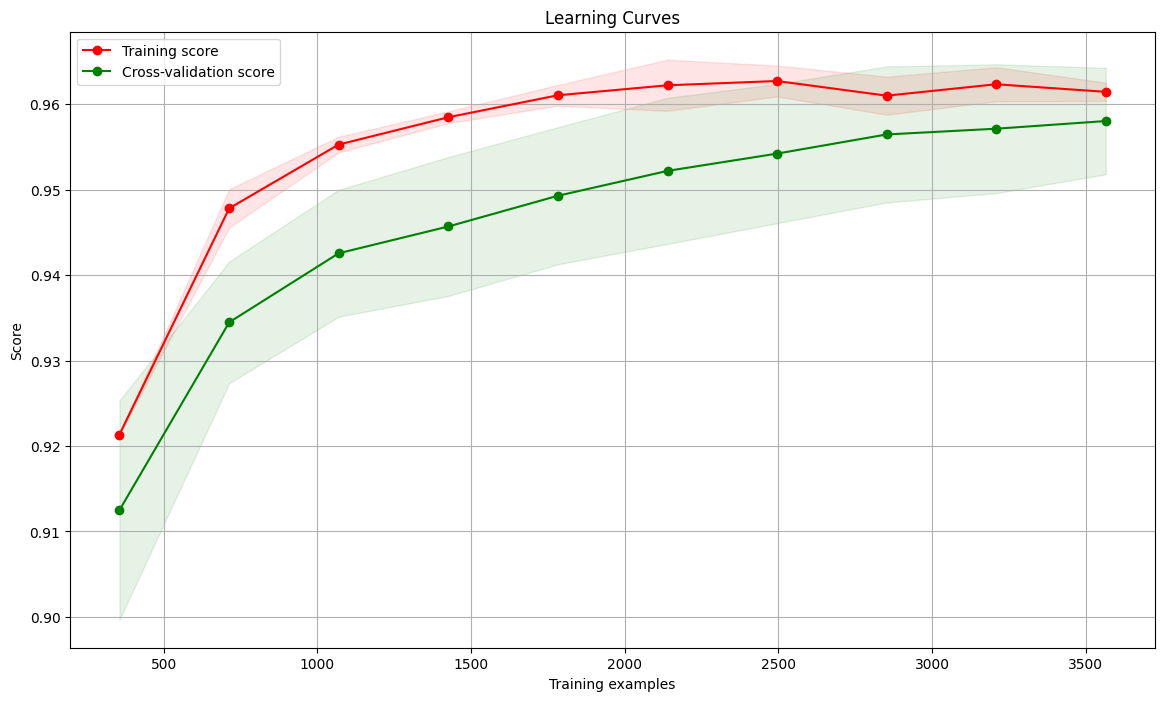

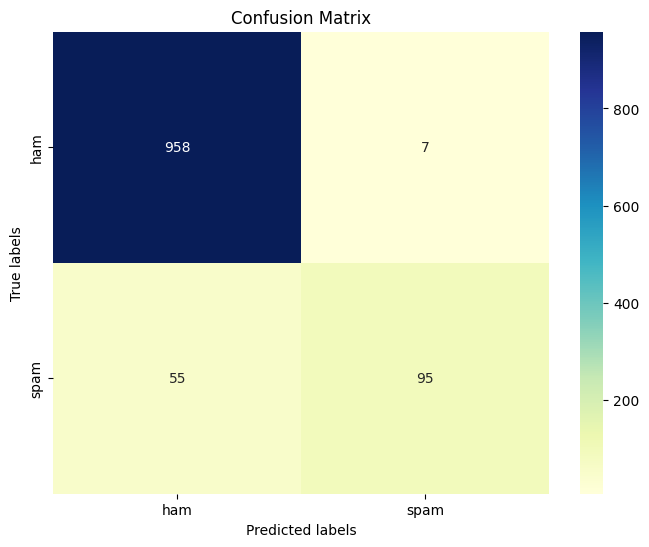

In [10]:
plot_learning_curves(model, X_train_tfidf, y_train, X_test_tfidf, y_test)
plot_confusion_matrix(y_test, y_pred, classes=model.classes_)

### Save the Best Model and Vectorizer

In [11]:
import joblib

# Save the best model and vectorizer
joblib.dump(best_model, 'sms_spam_classifier.pkl')
joblib.dump(count_vectorizer, 'count_vectorizer.pkl')
joblib.dump(tfidf_transformer, 'tfidf_transformer.pkl')


['tfidf_transformer.pkl']

### Load the Model and Vectorizer

In [12]:
# Load the model and vectorizer
loaded_model = joblib.load('sms_spam_classifier.pkl')
loaded_vectorizer = joblib.load('count_vectorizer.pkl')
loaded_tfidf_transformer = joblib.load('tfidf_transformer.pkl')

# Function to classify new messages
def classify_message(message):
    cleaned_message = preprocess_text(message)
    message_count = loaded_vectorizer.transform([cleaned_message])
    message_tfidf = loaded_tfidf_transformer.transform(message_count)
    prediction = loaded_model.predict(message_tfidf)
    return prediction[0]


### Example Usage

In [13]:
# Example usage
message = "Congratulations! You've won a FREE $1000 gift card. Call now to get the best deals!"
print(f'New Message: {message}')
print(f'Classification: {classify_message(message)}')


New Message: Congratulations! You've won a FREE $1000 gift card. Call now to get the best deals!
Classification: spam


In [14]:
new_message = "Hi! Howhave you been. I was looking forward to meet you after so long, how about we reschedule to sunday, at the starbucks near your place?"
print(f'New Message: {new_message}')
print(f'Classification: {classify_message(new_message)}')


New Message: Hi! Howhave you been. I was looking forward to meet you after so long, how about we reschedule to sunday, at the starbucks near your place?
Classification: ham
